# <span style="color:blue"> Esercitazione 4 - Simulazioni di dinamica molecolare, ensemble microcanonico </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 4.1 - Aggiunta del calcolo della pressione al simulatore](#Esercizio4.1)

- [Esercizio 4.2 - Simulazione della dinamica di un sistema di particelle di Argon](#Esercizio4.2)

In [652]:
import numpy as np
import matplotlib.pyplot as plt

## <span id="Esercizio4.1" style="color:blue">  Esercizio 4.1 - Aggiunta del calcolo della pressione al simulatore </span>[^](#toc)

### Il programma

In questo esercizio è stato implementato il calcolo della pressione all’interno di un codice già fornito (_MD_MC_, Molecular Dynamics / Monte Carlo), in grado di simulare la dinamica di un sistema di particelle classiche interagenti tramite potenziale di Lennard-Jones.

Il codice è stato utilizzato in modalità dinamica molecolare nell’ensemble microcanonico (NVE), cioè un sistema in cui il numero di particelle $N$, il volume $V$ e l’energia totale $E$ sono quantità conservate. L’evoluzione temporale è ottenuta integrando le equazioni del moto classiche per tutte le particelle.

Il simulatore ha le seguenti caratteristiche:
- il calcolo delle traiettorie si basa sull’algoritmo di Verlet: fissato un passo di integrazione $\delta t$, la posizione successiva di ogni particella è determinata a partire dalla posizione attuale, da quella precedente e dall’accelerazione, ottenuta dalla risultante delle forze esercitate dalle altre particelle;
- l’unica interazione tra le particelle è quella descritta dal potenziale di Lennard-Jones, che costituisce una buona approssimazione per sistemi semplici, come ad esempio atomi di gas nobili;
- al sistema sono applicate le _periodic boundary conditions_: la cella simulata viene replicata infinite volte nello spazio, in modo da approssimare un sistema esteso ed eliminare gli effetti di bordo;
- è introdotto un _cutoff_ nel potenziale: nel calcolo dell’energia potenziale della singola particella si trascura il contributo delle particelle a distanza maggiore di un raggio $r_{\mathrm{cutoff}}$. È stato scelto $r_{\mathrm{cutoff}}\geq2\sigma$, valore per cui il contributo dell’interazione è già sufficientemente piccolo;
- tutte le grandezze fisiche sono espresse in unità ridotte (unità di Lennard-Jones), così che il codice sia applicabile a diversi sistemi semplicemente variando i parametri adimensionali;
- la configurazione iniziale è una struttura cristallina regolare (FCC), anche quando non si intende simulare un solido. Questa scelta garantisce una configurazione iniziale ordinata e priva di sovrapposizioni tra particelle, da cui il sistema può poi rilassare verso lo stato di equilibrio corrispondente ai parametri termodinamici scelti.
- la configurazione iniziale è una struttura cristallina regolare (FCC), anche quando non si intende simulare un solido. Questa scelta evita sovrapposizioni tra particelle, che potrebbero verificarsi scegliendo configurazioni di partenza in modo casuale e che, qualora si verificassero, esse porterebbero a energie e forze estremamente grandi, rendendo l’integrazione numericamente instabile. A partire dalla configurazione ordinata, il sistema può poi rilassare verso lo stato di equilibrio corrispondente ai parametri termodinamici scelti.ticelle.

### Il calcolo

Le proprietà termodinamiche sono ottenute nel modo seguente.

1. L’integrazione delle equazioni del moto fornisce posizioni e velocità delle particelle $\vec r_i(t_k)$ e $\vec v_i(t_k)$, $\forall i=1,\dots,N$, corrispondenti a istanti temporali discreti $\{t_k\}_{k=0}^{M}$ separati dal passo di integrazione $\delta t$, con
$$t_k=t_{k-1}+\delta t\mathrm{,}\quad t_0=0$$
2. Ad ogni tempo $t_k$ si calcolano le grandezze termodinamiche istantanee:
    - Energia potenziale per particella: $$\frac{U(t_k)}{N}=\frac{1}{N}\sum_{i=1}^{N-1}\sum_{j=i+1}^{N}4\epsilon\left[ \left(\frac{\sigma}{r_{ij}(t_k)}\right)^{12}-\left(\frac{\sigma}{r_{ij}(t_k)}\right)^6\right]$$
      dove $r_{ij}\equiv|\vec{r}_i -\vec{r}_j|$. In unità ridotte (con $\sigma=1$, $\epsilon=1$): $$\frac{U^\star(t_k)}{N}=\frac{1}{N}\sum_{i=1}^{N-1}\sum_{j=i+1}^{N}4\left[ \left(\frac{1}{r_{ij}(t_k)}\right)^{12}-\left(\frac{1}{r_{ij}(t_k)}\right)^6\right]$$
    - Energia cinetica per particella: $$\frac{K(t_k)}{N}=\frac{1}{2N}\sum_{i=1}^{N}m\,v_i(t_k)^2$$
      che in unità ridotte ($m=1$, $\epsilon=1$)diventa $$\frac{K^\star(t_k)}{N}=\frac{1}{2N}\sum_{i=1}^{N}\,v_i(t_k)^2$$
    - Energia totale per particella: $$\frac{E(t_k)}{N}=\frac{U(t_k)+K(t_k)}{N}\mathrm{,} \quad \frac{E^\star(t_k)}{N}=\frac{U^\star(t_k)+K^\star(t_k)}{N}$$
    - Temperatura: $$T(t_k)=\frac{2}{3N k_B}K(t_k)\mathrm{,} \quad T^\star(t_k)=\frac{2}{3N}K^\star(t_k)$$
    - Pressione (aggiunta in questo esercizio), ottenuta tramite il teorema del viriale: $$P(t_k)=\rho k_BT(t_k)+\frac{1}{3V}\sum_{i=1}^{N-1}\sum_{j=i+1}^N 48\epsilon \left[ \left(\frac{\sigma}{r_{ij}(t_k)}\right)^{12}-\frac{1}{2}\left(\frac{\sigma}{r_{ij}(t_k)}\right)^6 \right]$$
      Che in unità naturali diventa $$P(t_k)=\rho^\star T^\star(t_k)+\frac{16}{V^\star}\sum_{i=1}^{N-1}\sum_{j=i+1}^N \left[ \frac{1}{r_{ij}^{12}(t_k)}-\frac{1}{2}\frac{1}{r_{ij}^6(t_k)} \right] \quad \mathrm{dove} \quad V^\star=\frac{V}{\sigma^3}=V \quad \mathrm{e} \quad \rho^\star=\frac{N}{V^\star}=\rho$$
3. Gli istanti ${t_k}$ vengono suddivisi in blocchi sufficientemente grandi e, all’interno di ciascun blocco, si eseguono medie temporali delle grandezze termodinamiche.

### L'equilibrazione

Nel caso della dinamica molecolare in ensemble NVE, l’energia totale del sistema è costante, mentre energia potenziale ed energia cinetica possono scambiarsi tra loro durante l’evoluzione temporale. Quando la simulazione parte da una configurazione iniziale artificiale (ad esempio un reticolo cristallino perfetto), il sistema non si trova in uno stato di equilibrio compatibile con i parametri termodinamici desiderati. In particolare, l’energia potenziale iniziale può essere significativamente diversa da quella caratteristica dello stato liquido o gassoso che si vuole simulare.

Poiché l’algoritmo di Verlet conserva l’energia totale, se durante l’evoluzione il sistema modifica la propria struttura (ad esempio, se si vuole simulare un liquido, all'inizio della simulazione si avrà un cristallo che si “scioglie”), l’energia potenziale varia e, di conseguenza, varia anche l’energia cinetica. Poiché la temperatura è proporzionale all’energia cinetica media, si osserva un cambiamento della temperatura rispetto al valore inizialmente impostato.

Di conseguenza, è necessario eseguire le misure delle osservabili termodinamiche dopo una fase di _equilibrazione_: si lascia evolvere il sistema per un numero sufficiente di passi temporali, monitorando grandezze come la temperatura, fino a quando esse iniziano ad oscillare attorno a un valore stazionario.
- Nel caso della simulazione liquida, si osserva che, partendo da una configurazione cristallina perfetta, la temperatura inizialmente diminuisce. Ciò è dovuto al fatto che, durante il rilassamento verso lo stato liquido, l’energia potenziale aumenta (il cristallo è una configurazione ordinata e stabile).
- Per ottenere una temperatura media di equilibrio pari a un valore desiderato $T^*$, è quindi necessario scegliere opportunamente una temperatura iniziale diversa da $T^*$. In pratica, si effettuano alcune simulazioni di prova finché, dopo il transiente iniziale, la temperatura oscilla attorno al valore target.

Infine, i valori medi e le incertezze progressive delle grandezze termodinamiche del sistema all'equilibrio devono essere calcolati escludendo la fase transiente: le medie vanno effettuate solo sui blocchi successivi al tempo di equilibrazione.

Di seguito si mostra l’andamento della temperatura istantanea (media di blocco) in funzione del numero di blocchi, ottenuta eseguendo una simulazione di un sistema di $N=108$ particelle, con densità $\rho^\star=0.8$, $r_{\mathrm{cutoff}}=2.2$ e temperatura iniziale $T^\star=1.49$, scelta affinché la temperatura di equilibrio sia $T^\star\simeq0.8$.

Sono stati utilizzati $2000$ blocchi con $10$ step per blocco, in modo da evidenziare chiaramente la fase di rilassamento verso l’equilibrio.

In [327]:
# Load the data (Temperature - block averages)
Path="../Es04_01/Output/output_temp.dat"
(
    BlockNumber,                # Block indexes
    T,                          # Block averages of T
)=np.loadtxt(Path,usecols=(0,1),unpack=True)

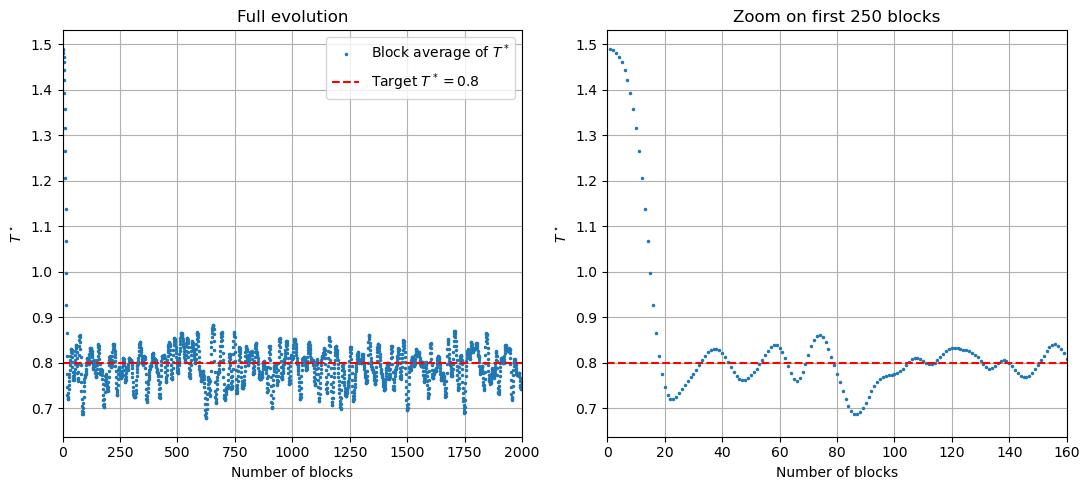

In [329]:
# Plot temperature as a function of the number of blocks

plt.figure(figsize=(11,5))
# --- Full evolution ---
plt.subplot(1,2,1)
plt.plot(BlockNumber,T,'.',markersize=3,label='Block average of $T^*$')
plt.axhline(0.8,color='r',linestyle='--',label='Target $T^*=0.8$')
plt.title('Full evolution')
plt.xlabel('Number of blocks')
plt.ylabel(r'$T^\star$')
plt.xlim(0,BlockNumber[-1])
plt.grid(True)
plt.legend()
# --- Zoom on first 250 blocks ---
plt.subplot(1,2,2)
plt.plot(BlockNumber,T,'.',markersize=3)
plt.axhline(0.8,color='r',linestyle='--')
plt.title('Zoom on first 250 blocks')
plt.xlabel('Number of blocks')
plt.ylabel(r'$T^\star$')
plt.xlim(0,160)
plt.grid(True)

plt.tight_layout()
plt.show()

Dal grafico si osserva che la fase transiente iniziale è molto rapida: la temperatura si stabilizza attorno al valore desiderato dopo circa $20$ blocchi ($200$ step temporali). A partire da questo punto, in questo caso, il sistema può considerarsi in equilibrio.

## <span id="Esercizio4.2" style="color:blue">  Esercizio 4.2 - Simulazione della dinamica di un sistema di particelle di Argon </span>[^](#toc)

### 0. Generalità

In questo esercizio sono state eseguite tre diverse simulazioni della dinamica di un sistema di $N=108$ atomi di Argon, corrispondenti a tre differenti fasi (solido, liquido e gas), utilizzando il codice testato nell’esercizio precedente. Il modello di interazione tra gli atomi è descritto dal potenziale di Lennard-Jones.

I parametri dimensionali dell’Argon sono:
- $\sigma = 0.34$ nm
- $\epsilon/k_B = 120$ K
- $m=39.948$ amu

In ogni simulazione sono stati ricavati i valori all’equilibrio delle grandezze $\frac{U}{N}$, $\frac{K}{N}$, $\frac{E}{N}$, $T$ e $P$, come medie temporali dei valori istantanei ottenuti durante l’evoluzione dinamica. I risultati finali e le relative incertezze sono stati stimati tramite il metodo della media a blocchi (si veda il notebook dell’_Esercizio 1.1_ per i dettagli). In particolare, per una generica osservabile $A$:
- si calcolano le medie temporali all’interno di ciascun blocco: $A_i$, $i=1,...,N_{\mathrm{blocks}}$. Esse rappresentano le medie temporali dell'osservabile in ciascun blocco.
- il valore medio progressivo fino al blocco $n$ è $$<A>_n=\frac{1}{n}\sum_{i=1}^{n}{A_i}$$
- l'incertezza progressiva fino al blocco $n$ è $$\sigma_{<A>_n}=\sqrt{\frac{<A^2>_n-<A>^2_n}{n-1}}=\sqrt{\frac{\frac{1}{n}\sum_{i=1}^{n}{A^2_i}-\left(\frac{1}{n}\sum_{i=1}^{n}{A_i}\right)^2}{n-1}}$$

Prima di eseguire le simulazioni di produzione, per ciascuna fase è stata effettuata una fase preliminare di equilibrazione:
- sono state monitorate le cinque osservabili di interesse per stabilire entro quanti passi temporali potessero essere considerate stazionarie;
- in particolare, è stata osservata la temperatura $T$, poiché, come mostrato in precedenza, il suo valore all’equilibrio non coincide in generale con quello iniziale assegnato e deve stabilizzarsi attorno al valore desiderato $T^\star$. È stata quindi determinata la temperatura iniziale $T^\star$ necessaria per ottenere, dopo il transiente, il valore stabile desiderato.

Una volta individuato il numero di step necessario all’equilibrazione, è stata eseguita una simulazione fino a tale istante e ne è stata salvata la configurazione finale. Successivamente, è stata avviata un'altra simulazione a partire da tale configurazione (modalità `restart`), e solo da questo punto sono state effettuate le misure delle osservabili.

Si sottolinea che il metodo della media a blocchi è applicato considerando come primo blocco un intervallo temporale successivo alla fase di equilibrazione.

Sono stati utilizzati $N_{\mathrm{blocks}}=$ blocchi e $L=$ misure per blocco. Il passo temporale è $\delta t^\star=0.005$, che corrisponde a un tempo fisico di $\delta t=\delta t^\star\sqrt{\frac{m\sigma^2}{\epsilon}}=1.08$ fs.

### i. Simulazione della fase solida

La fase solida è stata simulata con i seguenti parametri
- Densità: $\rho^\star = 1.1$
- Temperatura (dopo equilibrazione): $T^\star = 0.8$
- Raggio di cutoff: $r_c = 2.2$

Per raggiungere una temperatura di equilibrio di $T^\star = 0.8$, si è osservato che bisogna partire con $T^*=1.55$. Di seguito si mostrano le medie di blocco delle $5$ grandezze termodinamiche sotto esame, normalizzate per il valore finale della loro media progressiva, in funzione del numero del blocco, per una simulazione con dati iniziali $\rho^\star = 1.1$, $T^*=1.55$ e $r_c = 2.2$, e con $N_{\mathrm{blocks}}=500$ e $L=10$.

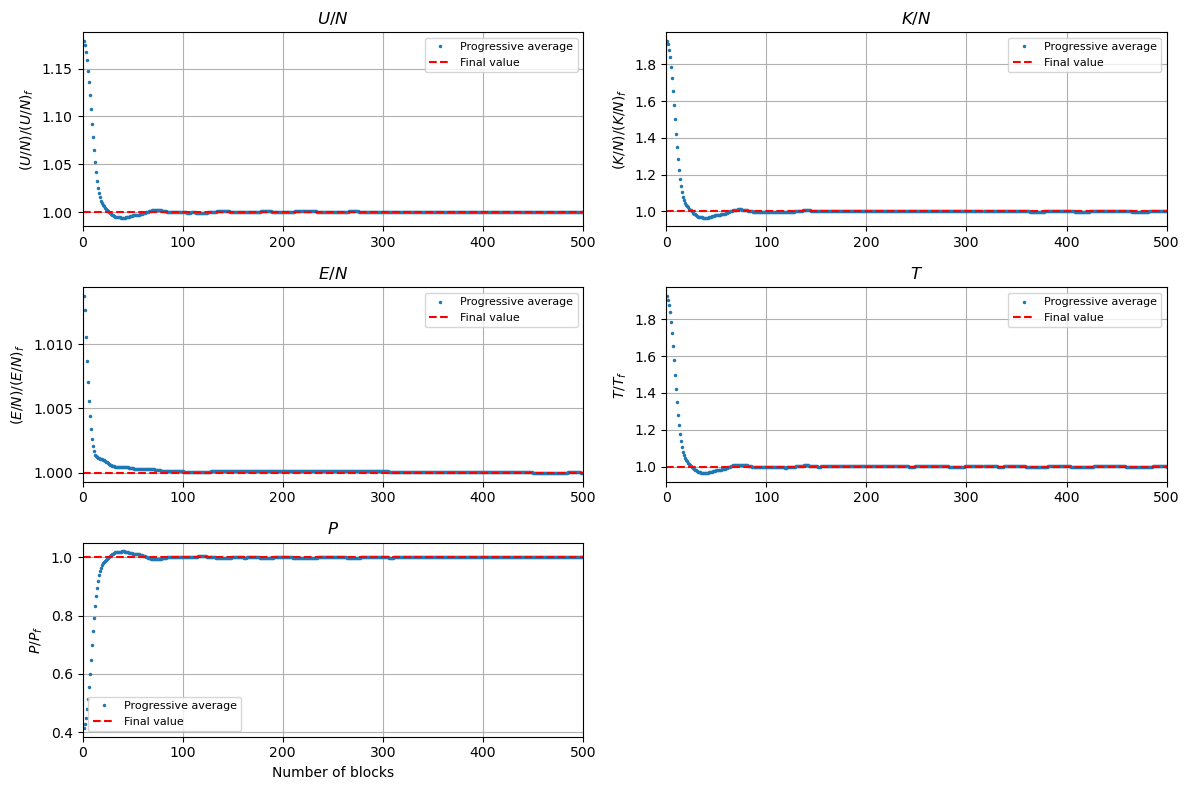

In [414]:
# Load progressive averages (column 2)
base_path="../Es04_02/Output/"
Block,U=np.loadtxt(base_path+"output_epot_trial_solid.dat",usecols=(0,2),unpack=True)    # The output files are renamed after program excecution 
_,K=np.loadtxt(base_path+"output_ekin_trial_solid.dat",usecols=(0,2),unpack=True)
_,E=np.loadtxt(base_path+"output_etot_trial_solid.dat",usecols=(0,2),unpack=True)
_,T=np.loadtxt(base_path+"output_temp_trial_solid.dat",usecols=(0,2),unpack=True)
_,P=np.loadtxt(base_path+"output_pres_trial_solid.dat",usecols=(0,2),unpack=True)

# Normalize to final value
U=U/U[-1]
K=K/K[-1]
E=E/E[-1]
T=T/T[-1]
P=P/P[-1]

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U,K,E,T,P]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$(U/N)/(U/N)_{f}$',r'$(K/N)/(K/N)_{f}$',r'$(E/N)/(E/N)_{f}$',r'$T/T_{f}$',r'$P/P_{f}$']

for i in range(5):
    axs[i].plot(Block,data[i],'.',markersize=3,
                label='Progressive average')
    axs[i].axhline(1.0,color='r',linestyle='--',
                   label='Final value')
    axs[i].set_title(titles[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].set_ylabel(ylabs[i])
    axs[i].legend(fontsize=8)
    axs[i].grid(True)
axs[4].set_xlabel('Number of blocks')
axs[5].axis('off')  # empty panel
plt.tight_layout()
plt.show()

Dopo circa $200$ blocchi, ovvero $2000$ step di integrazione, tutte le osservabili oscillano stabilmente attorno ai rispettivi valori stazionari. Il sistema può quindi essere considerato in equilibrio a partire da questo istante. I file contenenti i dati dell’equilibrazione sono stati rinominati, in modo da conservarli anche dopo successive esecuzioni del programma.

È stata quindi eseguita una simulazione preliminare di $200$ blocchi ($10$ step per blocco) con temperatura iniziale $T^*=1.55$, al termine della quale sono state salvate le configurazioni finali di posizioni e velocità. I file di output relativi alle osservabili sono stati successivamente eliminati. La simulazione "effettiva" (questa volta con $T^\star=0.8$) è stata avviata in modalità restart, caricando le configurazioni finali della simulazione di equilibrazione. Essa è stata eseguita con $50$ blocchi da $2000$ step ciascuno.

Di seguito si mostrano i risultati ottenuti (medie progressive, con barre di erroe date dalle incertezze statistiche progressive) della simulazione equilibrata.

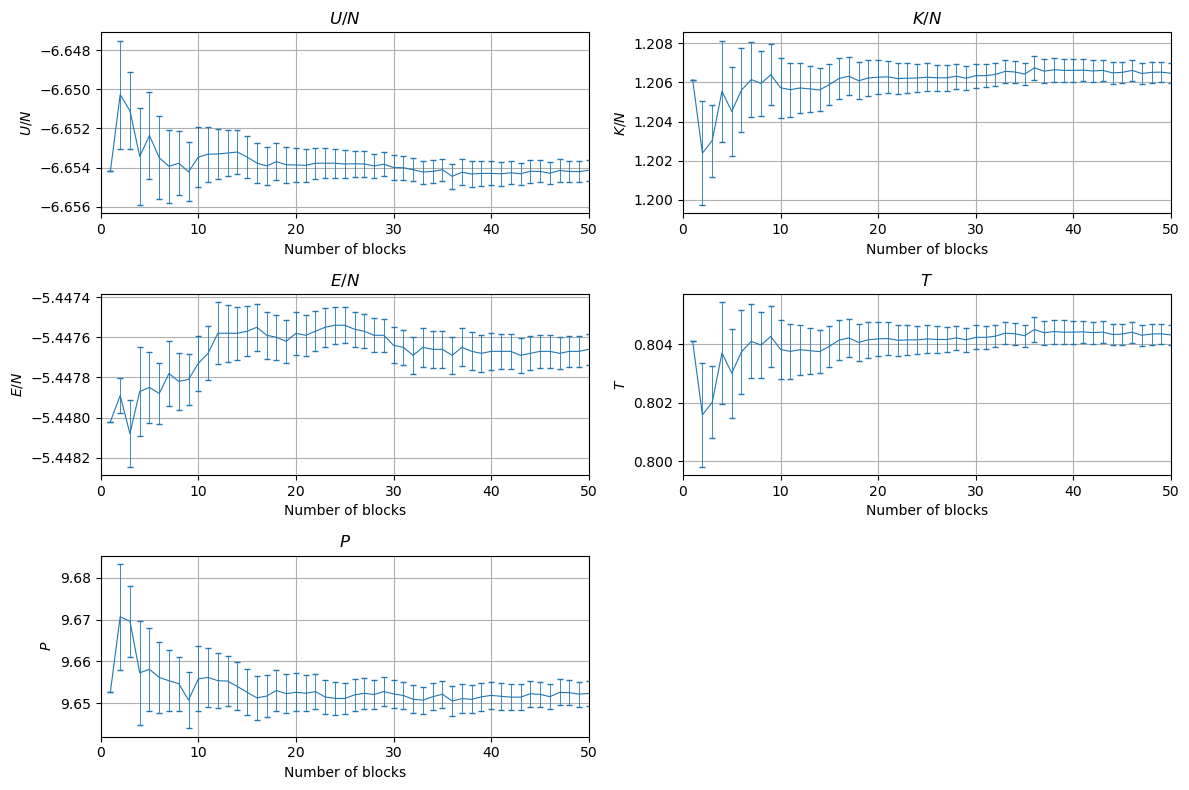

In [451]:
# Load progressive averages and errors
Block,U_s,Uerr_s=np.loadtxt(base_path+"output_epot_solid.dat",usecols=(0,2,3),unpack=True)    # The output files are renamed after program excecution 
_,K_s,Kerr_s=np.loadtxt(base_path+"output_ekin_solid.dat",usecols=(0,2,3),unpack=True)
_,E_s,Eerr_s=np.loadtxt(base_path+"output_etot_solid.dat",usecols=(0,2,3),unpack=True)
_,T_s,Terr_s=np.loadtxt(base_path+"output_temp_solid.dat",usecols=(0,2,3),unpack=True)
_,P_s,Perr_s=np.loadtxt(base_path+"output_pres_solid.dat",usecols=(0,2,3),unpack=True)

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U_s,K_s,E_s,T_s,P_s]
err=[Uerr_s,Kerr_s,Eerr_s,Terr_s,Perr_s]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$U/N$',r'$K/N$',r'$E/N$',r'$T$',r'$P$']
for i in range(5):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
axs[5].axis('off')
plt.tight_layout()
plt.show()

### ii. Simulazione della fase liquida

La fase liquida è stata simulata con i seguenti parametri
- Densità: $\rho^\star = 0.8$
- Temperatura: $T^\star = 1.1$
- Raggio di cutoff: $r_c = 2.5$

Per raggiungere una temperatura di equilibrio di $T^\star = 1.1$, si è osservato che bisogna partire con $T^*=1.98$. Di seguito si mostrano le medie di blocco delle $5$ grandezze termodinamiche sotto esame, normalizzate per il valore finale della loro media progressiva, in funzione del numero del blocco, per una simulazione con dati iniziali $\rho^\star = 0.8$, $T^*=1.98$ e $r_c = 2.5$, e con $N_{\mathrm{blocks}}=1500$ e $L=10$.

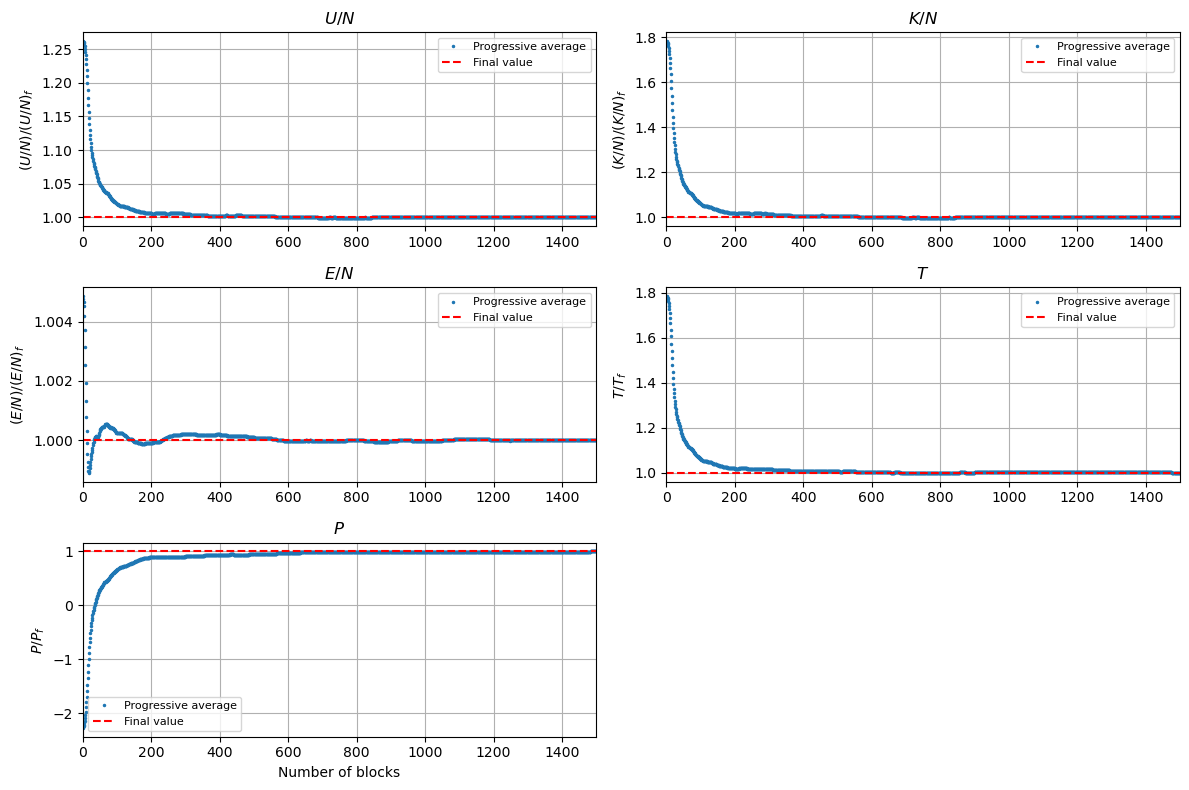

In [422]:
# Load progressive averages (column 2)
base_path="../Es04_02/Output/"
Block,U=np.loadtxt(base_path+"output_epot_trial_liquid.dat",usecols=(0,2),unpack=True)    # The output files are renamed after program excecution 
_,K=np.loadtxt(base_path+"output_ekin_trial_liquid.dat",usecols=(0,2),unpack=True)
_,E=np.loadtxt(base_path+"output_etot_trial_liquid.dat",usecols=(0,2),unpack=True)
_,T=np.loadtxt(base_path+"output_temp_trial_liquid.dat",usecols=(0,2),unpack=True)
_,P=np.loadtxt(base_path+"output_pres_trial_liquid.dat",usecols=(0,2),unpack=True)

# Normalize to final value
U=U/U[-1]
K=K/K[-1]
E=E/E[-1]
T=T/T[-1]
P=P/P[-1]

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U,K,E,T,P]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$(U/N)/(U/N)_{f}$',r'$(K/N)/(K/N)_{f}$',r'$(E/N)/(E/N)_{f}$',r'$T/T_{f}$',r'$P/P_{f}$']

for i in range(5):
    axs[i].plot(Block,data[i],'.',markersize=3,
                label='Progressive average')
    axs[i].axhline(1.0,color='r',linestyle='--',
                   label='Final value')
    axs[i].set_title(titles[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].set_ylabel(ylabs[i])
    axs[i].legend(fontsize=8)
    axs[i].grid(True)
axs[4].set_xlabel('Number of blocks')
axs[5].axis('off')  # empty panel
plt.tight_layout()
plt.show()

Dopo circa $600$ blocchi, ovvero $6000$ step di integrazione, tutte le osservabili oscillano stabilmente attorno ai rispettivi valori stazionari. Il sistema può quindi essere considerato in equilibrio a partire da questo istante. I file contenenti i dati dell’equilibrazione sono stati rinominati, in modo da conservarli anche dopo successive esecuzioni del programma.

È stata eseguita una simulazione preliminare di $600$ blocchi ($10$ step per blocco) con temperatura iniziale $T^*=1.98$, al termine della quale sono state salvate le configurazioni finali di posizioni e velocità. I file di output relativi alle osservabili sono stati successivamente eliminati. La simulazione "effettiva" (questa volta con $T^\star=1.1$) è stata avviata in modalità restart, caricando le configurazioni finali della simulazione di equilibrazione. Essa è stata eseguita con $50$ blocchi da $2000$ step ciascuno.

Di seguito si mostrano i risultati ottenuti (medie progressive, con barre di erroe date dalle incertezze statistiche progressive) della simulazione equilibrata.

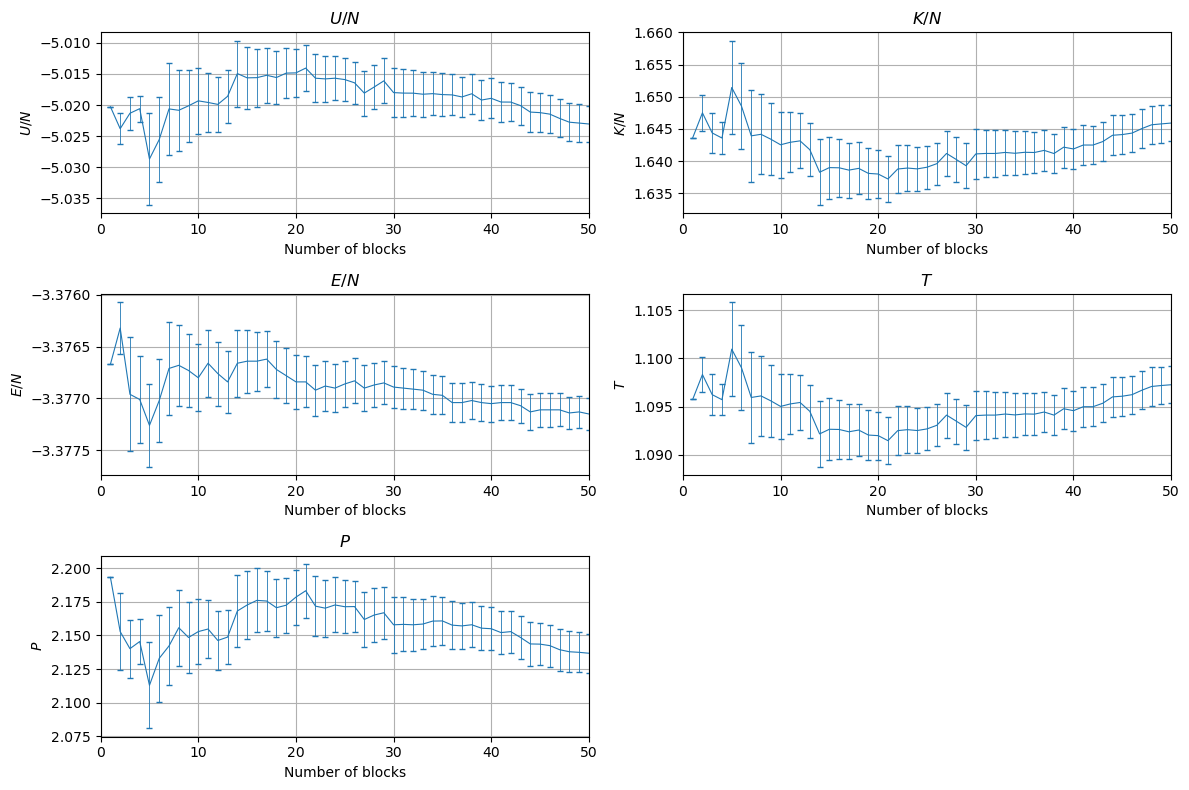

In [455]:
# Load progressive averages and errors
Block,U_l,Uerr_l=np.loadtxt(base_path+"output_epot_liquid.dat",usecols=(0,2,3),unpack=True)    # The output files are renamed after program excecution 
_,K_l,Kerr_l=np.loadtxt(base_path+"output_ekin_liquid.dat",usecols=(0,2,3),unpack=True)
_,E_l,Eerr_l=np.loadtxt(base_path+"output_etot_liquid.dat",usecols=(0,2,3),unpack=True)
_,T_l,Terr_l=np.loadtxt(base_path+"output_temp_liquid.dat",usecols=(0,2,3),unpack=True)
_,P_l,Perr_l=np.loadtxt(base_path+"output_pres_liquid.dat",usecols=(0,2,3),unpack=True)

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U_l,K_l,E_l,T_l,P_l]
err=[Uerr_l,Kerr_l,Eerr_l,Terr_l,Perr_l]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$U/N$',r'$K/N$',r'$E/N$',r'$T$',r'$P$']
for i in range(5):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
axs[5].axis('off')
plt.tight_layout()
plt.show()

### iii. Simulazione della fase gassosa

La fase gassosa è stata simulata con i seguenti parametri
- Densità: $\rho^\star = 0.05$
- Temperatura: $T^\star = 1.2$
- Raggio di cutoff: $r_c = 5.0$

Per raggiungere una temperatura di equilibrio di $T^\star = 1.2$, si è osservato che bisogna partire con $T^*=0.97$. Di seguito si mostrano le medie di blocco delle $5$ grandezze termodinamiche sotto esame, normalizzate per il valore finale della loro media progressiva, in funzione del numero del blocco, per una simulazione con dati iniziali $\rho^\star = 0.05$, $T^*=0.97$ e $r_c = 5.0$, e con $N_{\mathrm{blocks}}=2000$ e $L=200$.

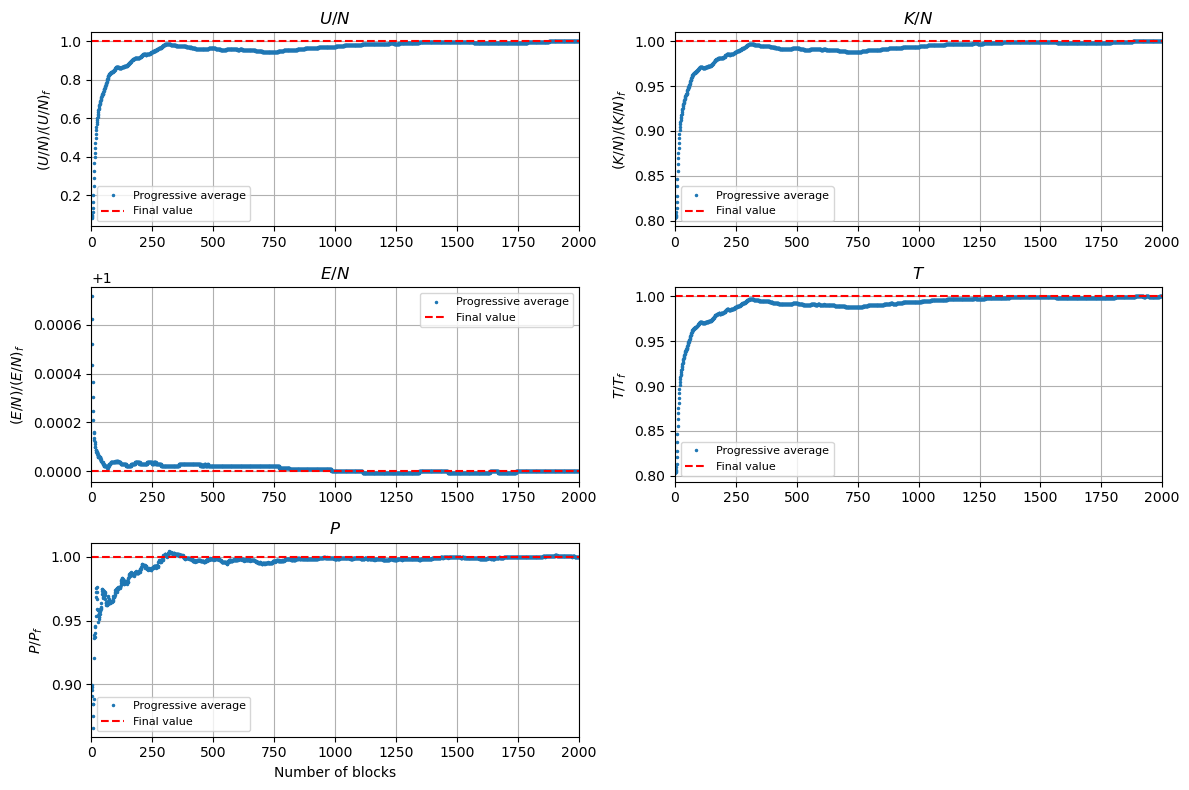

In [440]:
# Load progressive averages (column 2)
base_path="../Es04_02/Output/"
Block,U=np.loadtxt(base_path+"output_epot_trial_gas.dat",usecols=(0,2),unpack=True)    # The output files are renamed after program excecution 
_,K=np.loadtxt(base_path+"output_ekin_trial_gas.dat",usecols=(0,2),unpack=True)
_,E=np.loadtxt(base_path+"output_etot_trial_gas.dat",usecols=(0,2),unpack=True)
_,T=np.loadtxt(base_path+"output_temp_trial_gas.dat",usecols=(0,2),unpack=True)
_,P=np.loadtxt(base_path+"output_pres_trial_gas.dat",usecols=(0,2),unpack=True)

# Normalize to final value
U=U/U[-1]
K=K/K[-1]
E=E/E[-1]
T=T/T[-1]
P=P/P[-1]

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U,K,E,T,P]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$(U/N)/(U/N)_{f}$',r'$(K/N)/(K/N)_{f}$',r'$(E/N)/(E/N)_{f}$',r'$T/T_{f}$',r'$P/P_{f}$']

for i in range(5):
    axs[i].plot(Block,data[i],'.',markersize=3,
                label='Progressive average')
    axs[i].axhline(1.0,color='r',linestyle='--',
                   label='Final value')
    axs[i].set_title(titles[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].set_ylabel(ylabs[i])
    axs[i].legend(fontsize=8)
    axs[i].grid(True)
axs[4].set_xlabel('Number of blocks')
axs[5].axis('off')  # empty panel
plt.tight_layout()
plt.show()

La simulazione dello stato gassoso richiede un tempo molto maggiore perché l'equilibrazione possa dirsi terminata. Si può prendere, come riferimento oltre al quale tutte le osservabili oscillano stabilmente attorno ai rispettivi valori stazionari, $1500$ blocchi, che corrispondono a $300000$ step di integrazione. Il sistema può quindi essere considerato in equilibrio a partire da questo istante. I file contenenti i dati dell’equilibrazione sono stati rinominati, in modo da conservarli anche dopo successive esecuzioni del programma.

È stata eseguita una simulazione preliminare di $1500$ blocchi ($200$ step per blocco) con temperatura iniziale $T^*=0.97$, al termine della quale sono state salvate le configurazioni finali di posizioni e velocità. I file di output relativi alle osservabili sono stati successivamente eliminati. La simulazione "effettiva" (questa volta con $T^\star=1.2$) è stata avviata in modalità restart, caricando le configurazioni finali della simulazione di equilibrazione. Essa è stata eseguita con $100$ blocchi da $2000$ step ciascuno.

Di seguito si mostrano i risultati ottenuti (medie progressive, con barre di erroe date dalle incertezze statistiche progressive) della simulazione equilibrata.

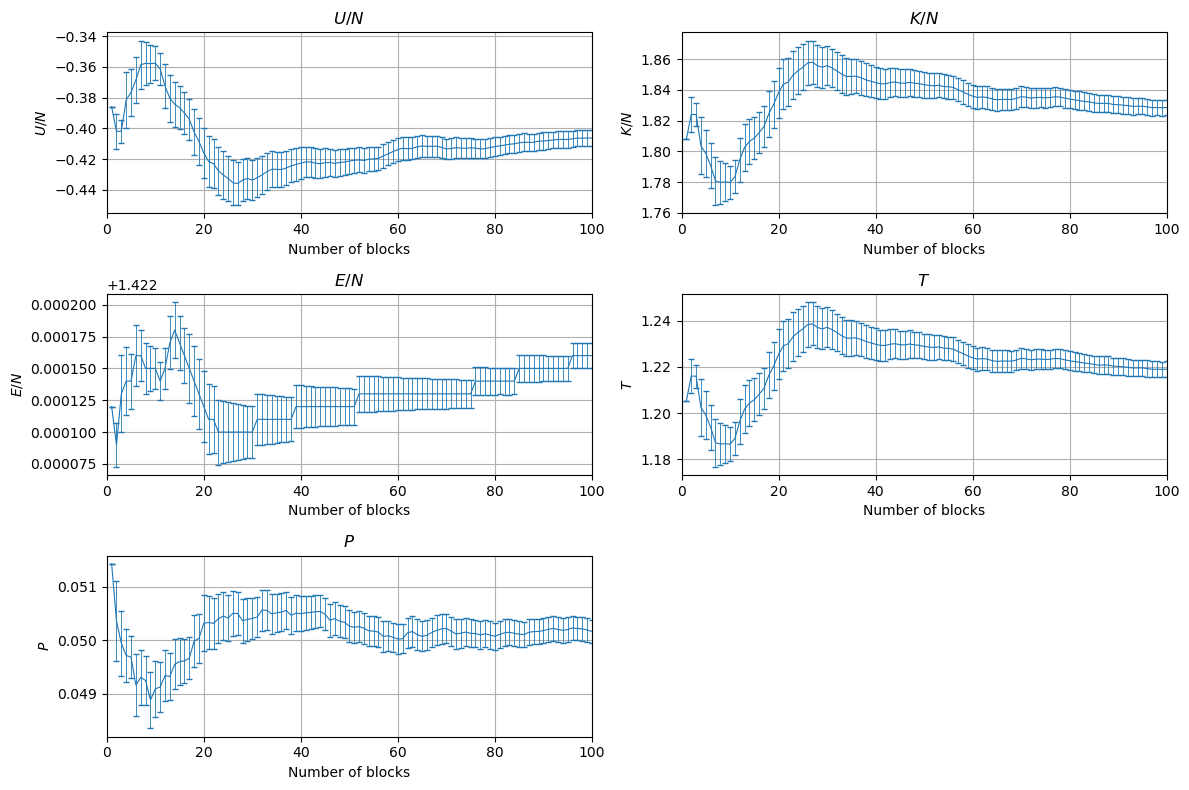

In [457]:
# Load progressive averages and errors
Block,U_g,Uerr_g=np.loadtxt(base_path+"output_epot_gas.dat",usecols=(0,2,3),unpack=True)     # The output files are renamed after program excecution
_,K_g,Kerr_g=np.loadtxt(base_path+"output_ekin_gas.dat",usecols=(0,2,3),unpack=True)
_,E_g,Eerr_g=np.loadtxt(base_path+"output_etot_gas.dat",usecols=(0,2,3),unpack=True)
_,T_g,Terr_g=np.loadtxt(base_path+"output_temp_gas.dat",usecols=(0,2,3),unpack=True)
_,P_g,Perr_g=np.loadtxt(base_path+"output_pres_gas.dat",usecols=(0,2,3),unpack=True)

fig,axs=plt.subplots(3,2,figsize=(12,8))
axs=axs.flatten()
data=[U_g,K_g,E_g,T_g,P_g]
err=[Uerr_g,Kerr_g,Eerr_g,Terr_g,Perr_g]
titles=['$U/N$','$K/N$','$E/N$','$T$','$P$']
ylabs=[r'$U/N$',r'$K/N$',r'$E/N$',r'$T$',r'$P$']
for i in range(5):
    axs[i].errorbar(Block,data[i],yerr=err[i],fmt='-',linewidth=0.8,elinewidth=0.6,capsize=2)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Number of blocks')
    axs[i].set_ylabel(ylabs[i])
    axs[i].set_xlim(0,Block[-1])
    axs[i].grid(True)
axs[5].axis('off')
plt.tight_layout()
plt.show()

### iv. Confronto

Di seguito si riportano i risultati delle simulazioni
- in unità ridotte
- in unità del SI. Le conversioni effettuate sono le seguenti:
    - $U=\epsilon U^\star$, $K=\epsilon K^\star$, $E=\epsilon E^\star$
    - $T=\frac{\epsilon}{k_B}T^\star$
    - $P=\frac{\epsilon}{\sigma^3}P^\star$

In [644]:
kB=1.380649e-23
eps=120*kB
sigma=0.34e-09
q=1.602177e-19

print(f"----- Solid -----")
print(f"Potential energy per particle: {U_s[-1]:.5f}  ±{Uerr_s[-1]:.5f} ----->  ( {U_s[-1]*eps/q*1000:.4f} ±{Uerr_s[-1]*eps/q*1000:.4f} ) meV")
print(f"Kinetic energy per particle:    {K_s[-1]:.5f}  ±{Kerr_s[-1]:.5f} ----->  (  {K_s[-1]*eps/q*1000:.4f} ±{Kerr_s[-1]*eps/q*1000:.4f} ) meV")
print(f"Total energy per particle:     {E_s[-1]:.5f}  ±{Eerr_s[-1]:.5f} ----->  ( {E_s[-1]*eps/q*1000:.5f}±{Eerr_s[-1]*eps/q*1000:.5f}) meV")
print(f"Temperature:                    {T_s[-1]:.5f}  ±{Terr_s[-1]:.5f} ----->  (  {T_s[-1]*eps/kB:.3f}  ±{Terr_s[-1]*eps/kB:.3f}  ) K")
print(f"Pressure:                       {P_s[-1]:.4f}   ±{Perr_s[-1]:.4f}  ----->  ({P_s[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_s[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")
print(f"----- Liquid ----")
print(f"Potential energy per particle: {U_l[-1]:.4f}   ±{Uerr_l[-1]:.4f}  ----->  ( {U_l[-1]*eps/q*1000:.3f}  ±{Uerr_l[-1]*eps/q*1000:.3f}  ) meV")
print(f"Kinetic energy per particle:    {K_l[-1]:.4f}   ±{Kerr_l[-1]:.4f}  ----->  (  {K_l[-1]*eps/q*1000:.3f}  ±{Kerr_l[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:     {E_l[-1]:.4f}   ±{Eerr_l[-1]:.4f}  ----->  ( {E_l[-1]*eps/q*1000:.4f} ±{Eerr_l[-1]*eps/q*1000:.4f} ) meV")
print(f"Temperature:                    {T_l[-1]:.4f}   ±{Terr_l[-1]:.4f}  ----->  ( {T_l[-1]*eps/kB:.2f}   ±{Terr_l[-1]*eps/kB:.2f}   ) K")
print(f"Pressure:                       {P_l[-1]:.3f}    ±{Perr_l[-1]:.3f}   ----->  ( {P_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ±{Perr_l[-1]*eps/(sigma)**3*10**(-5):.1f}    ) bar")
print(f"----- Gas ------")
print(f"Potential energy per particle: {U_g[-1]:.4f}   ±{Uerr_g[-1]:.4f}  ----->  (  {U_g[-1]*eps/q*1000:.3f}  ±{Uerr_g[-1]*eps/q*1000:.3f}  ) meV")
print(f"Kinetic energy per particle:    {K_g[-1]:.4f}   ±{Kerr_g[-1]:.4f}  ----->  (  {K_g[-1]*eps/q*1000:.3f}  ±{Kerr_g[-1]*eps/q*1000:.3f}  ) meV")
print(f"Total energy per particle:      {E_g[-1]:.6f} ±{Eerr_g[-1]:.6f}----->  (  {E_g[-1]*eps/q*1000:.5f}±{Eerr_g[-1]*eps/q*1000:.5f}) meV")
print(f"Temperature:                    {T_g[-1]:.4f}   ±{Terr_g[-1]:.4f}  ----->  ( {T_g[-1]*eps/kB:.2f}   ±{Terr_g[-1]*eps/kB:.2f}   ) K")
print(f"Pressure:                       {P_g[-1]:.5f}  ±{Perr_g[-1]:.5f} ----->  (  {P_g[-1]*eps/(sigma)**3*10**(-5):.3f}  ±{Perr_g[-1]*eps/(sigma)**3*10**(-5):.3f}  ) bar")

----- Solid -----
Potential energy per particle: -6.65413  ±0.00054 ----->  ( -68.8090 ±0.0055 ) meV
Kinetic energy per particle:    1.20647  ±0.00052 ----->  (  12.4759 ±0.0054 ) meV
Total energy per particle:     -5.44766  ±0.00008 ----->  ( -56.33315±0.00078) meV
Temperature:                    0.80432  ±0.00035 ----->  (  96.518  ±0.042  ) K
Pressure:                       9.6524   ±0.0029  ----->  (4068.8    ±1.2    ) bar
----- Liquid ----
Potential energy per particle: -5.0231   ±0.0029  ----->  ( -51.942  ±0.030  ) meV
Kinetic energy per particle:    1.6459   ±0.0029  ----->  (  17.020  ±0.030  ) meV
Total energy per particle:     -3.3771   ±0.0002  ----->  ( -34.9224 ±0.0016 ) meV
Temperature:                    1.0973   ±0.0019  ----->  ( 131.67   ±0.23   ) K
Pressure:                       2.137    ±0.015   ----->  ( 900.7    ±6.2    ) bar
----- Gas ------
Potential energy per particle: -0.4063   ±0.0051  ----->  (  -4.202  ±0.052  ) meV
Kinetic energy per particle:    1.8285

Si può osservare che l'incertezza sulla pressione risulta essere
- un ordine di grandezza maggiore delle altre incertezze per i casi solido e liquido
- un ordine di grandezza minore delle altre incertezze per il caso gassoso